# Characterizing the performance of relay-bp with the rotated surface code
In this notebook we tune Relay-BP for the rotated surface code under circuit-level noise.

This guide assumes you have installed Relay-BP as described in the [Readme](../README.md) with the Stim option. For comparison we
also assume Pymatching is installed. For gradient free optimization of Relay parameters we use [`nevergrad`](https://github.com/facebookresearch/nevergrad) which should also be installed.

To install:

```bash
pip install ".[stim]" pymatching nevergrad seaborn
```



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import stim
import sinter
import numpy as np
from scipy.sparse import csc_matrix

from relay_bp.stim import SinterDecoder_RelayBP, SinterDecoder_MemBP, SinterDecoder_MSLBP, sinter_decoders

import sys
sys.path.append(str(Path("../tests").resolve()))
import testdata

## Let's set the notebook parameters

We will store our data to a directory to avoid having to re-run simulations more than once

In [3]:
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

# Enable testing parameters, set to True for a quick check with a smaller code
test = False

# If set False the default parameters will be used and only the PER vs. LER plot will be generated
# If test is set to True, highly unoptimized results will be obtained
optimize = False

# Use saved data
load_data = True

# Save data from any runs we perform
save_data = True

Now let's choose the parameters which we will use to control the notebook execution

In [4]:
# X/Z basis circuits to be characterized together in post-processing

notebook_str = "rotated_surface_code"
circuits = ["rotated_surface_code_memory_X", "rotated_surface_code_memory_Z"]
noise_model = "uniform_circuit"

# Distance of the code
if test:
    distance = 5
else:
    distance = 11

# Number of circuit rounds
rounds = distance

opt_error_rate = 0.003

if test:
    error_rates = [0.001, 0.002, 0.003]
else:
    error_rates = [0.001, 0.002, 0.003, 0.004, 0.005]

def rough_select_num_shots(p: float) -> int:
    """Number of shots for a given error rate"""
    if p >= 0.005:
        return 500
    elif p < 0.005 and p >= 0.004:
        return 500
    elif p < 0.004 and p >= 0.003:
        return 1_000
    elif p < 0.003 and p >= 0.002:
        return 5_000
    return 5_000

def normal_select_num_shots(p: float) -> int:
    """Number of shots for a given error rate"""
    if p >= 0.005:
        return 3_000
    elif p < 0.005 and p >= 0.004:
        return 5_000
    elif p < 0.004 and p >= 0.003:
        return 10_000
    elif p < 0.003 and p >= 0.002:
        return 100_000
    return 1_000_000

def fine_select_num_shots(p: float) -> int:
    """Number of shots for a given error rate"""
    if p >= 0.005:
        return 5_000
    elif p < 0.005 and p >= 0.004:
        return 10_000
    elif p < 0.004 and p >= 0.003:
        return 100_000
    elif p < 0.003 and p >= 0.002:
        return 1_000_000
    return 10_000_000

if test:
    select_num_shots = rough_select_num_shots
else:
    select_num_shots = fine_select_num_shots


In [5]:
# Some good defaults
gamma0 = 0.65
alpha = 1.
relay_gamma_dist_interval = [-0.25453802248, 0.98518104204]

if test:
    msl_max_iter = 200
    relay_num_sets = 60
    relay_num_pre_iter = 80
    relay_set_max_iter = 60
    relay_stop_nconv = 1
else:
    msl_max_iter = 10000
    relay_num_sets = 300
    relay_num_pre_iter = 80
    relay_set_max_iter = 60
    relay_stop_nconv = 5


def build_relay_params(**kwargs):
    params = {
        "alpha": alpha,
        "gamma0": gamma0,
        "gamma_dist_interval": relay_gamma_dist_interval,
        "num_sets": relay_num_sets,
        "pre_iter": relay_num_pre_iter,
        "set_max_iter": relay_set_max_iter,
        "stop_nconv": relay_stop_nconv,
    }
    if kwargs:
        params.update(kwargs)
    return params

def build_msl_params(**kwargs):
    params = {
        "alpha": alpha,
        "max_iter": msl_max_iter,
    }
    if kwargs:
        params.update(kwargs)
    return params

def build_mem_params(**kwargs):
    params = {
        "alpha": alpha,
        "max_iter": msl_max_iter,
        "gamma0": gamma0,
    }
    if kwargs:
        params.update(kwargs)
    return params

default_relay_params = build_relay_params()
default_msl_params = build_msl_params()
default_mem_params = build_mem_params()

## We now select the decoders we want to make available

In [6]:
default_custom_decoders = sinter_decoders(**build_relay_params())

all_decoders = list(sinter_decoders().keys()) + ["pymatching"]
xz_only_decoders = ["pymatching"]
default_decoders = all_decoders


print(f"The decoders we will compare {default_decoders}")

The decoders we will compare ['relay-bp', 'mem-bp', 'msl-bp', 'pymatching']


We add a bit of custom machinery to avoid regenerating data depending on how we want to use the notebook

In [7]:
def load_path(experiment_name) -> Path | None:
    if load_data and not save_data:
        path = data_dir / f"{notebook_str}_{experiment_name}.csv"
        if path.exists():
            return [data_dir / f"{notebook_str}_{experiment_name}.csv"]
    return []

def save_path(experiment_name) -> Path | None:
    if save_data:
        return data_dir / f"{notebook_str}_{experiment_name}.csv"
    return None

We also add a wrapper around circuit generation to enable different noise models

In [8]:
import multiprocessing

from relay_bp.stim.sinter.utils import write_stats

num_notebook_workers = multiprocessing.cpu_count()


def sinter_collect(tasks, exp_name, num_workers=None, custom_decoders=None, start_batch_size=10_000, save=True, load=True, consolidate_samples=True, **sinter_kwargs):
    if num_workers is None:
        num_workers = num_notebook_workers

    if custom_decoders is None:
        custom_decoders = default_custom_decoders

    save_file = save_path(exp_name) if save else None
    samples = sinter.collect(
        tasks=tasks,
        num_workers=num_workers, 
        existing_data_filepaths=load_path(exp_name) if load else [],
        save_resume_filepath=save_file,
        custom_decoders=custom_decoders,
        start_batch_size=start_batch_size,
        **sinter_kwargs
    )

    if consolidate_samples and save:
        write_stats(samples, save_file)

    return samples
        

## Tuning Relay-BP memory factor

Relay has several parameters such as the uniform memory factor for the initial set run, and relay gamma distribution values that should be tuned to the specific code. 

We explore this below. First we explore the initial uniform factor and then we use gradient free optimization to tune the relay distribution parameters.

In [9]:
# Generates surface code circuit tasks using Stim's circuit generation.

if test:
    membp_gamma0s = np.linspace(0, 1, 11)
    membp_error_rates = [opt_error_rate]
    membp_distances = [distance]
    membp_sweep_max_iter = 80
    membp_sweep_xyz = False
else:
    # Sweep out phase transition in more detail
    membp_gamma0s = np.linspace(0, 1, 21).tolist()
    membp_error_rates = [opt_error_rate]
    membp_distances = [distance]
    membp_sweep_max_iter = 80
    membp_sweep_xyz = True
    

def generate_gamma0_tasks(decoder_params):
    for d in membp_distances:
        for membp_error_rate in membp_error_rates:
            for circuit_name in circuits:
                circ = testdata.get_test_circuit(circuit_name, distance=d, rounds=d, error_rate=membp_error_rate)
                if not membp_sweep_xyz:
                    circ = testdata.filter_detectors_by_basis(circ, circuit_name[-1])
                dem = circ.detector_error_model(decompose_errors=not membp_sweep_xyz)
                yield sinter.Task(
                    circuit=circ,
                    detector_error_model=dem,
                    decoder="mem-bp",
                    json_metadata={
                        'circuit': circuit_name,
                        'p': membp_error_rate,
                        'd': d,
                        'r': d,
                        'decoder_params': decoder_params,
                        'xyz': membp_sweep_xyz,
                    },
                    collection_options=sinter.CollectionOptions(max_shots=rough_select_num_shots(membp_error_rate))
                )

def collect_gamma0_sweep_samples():
    samples = []
    for gamma0 in membp_gamma0s:
        print(f"Starting collection of membp gamma0: {gamma0:.2f}")
        decoder_params = build_mem_params(gamma0=gamma0, max_iter=membp_sweep_max_iter)
        circuit_samples = sinter_collect(
            generate_gamma0_tasks(decoder_params), 
            exp_name="gamma0_sweep", 
            custom_decoders={"mem-bp": SinterDecoder_MemBP(**decoder_params)},
            save=save_data,
            load=load_data,
        )
        synthesized_samples = testdata.synthesize_joint_samples(circuit_samples, circuits)
        samples += circuit_samples

    return samples

gamma0_sweep_samples = collect_gamma0_sweep_samples()

Starting collection of membp gamma0: 0.00


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/synchronize.py", line 115, in __setstate__
    self._semlock = _multiprocessing.SemLock._rebuild(*state)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory


Starting collection of membp gamma0: 0.05
Starting collection of membp gamma0: 0.10
Starting collection of membp gamma0: 0.15


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/synchronize.py", line 115, in __setstate__
    self._semlock = _multiprocessing.SemLock._rebuild(*state)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory


Starting collection of membp gamma0: 0.20
Starting collection of membp gamma0: 0.25
Starting collection of membp gamma0: 0.30
Starting collection of membp gamma0: 0.35


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/synchronize.py", line 115, in __setstate__
    self._semlock = _multiprocessing.SemLock._rebuild(*state)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory


Starting collection of membp gamma0: 0.40
Starting collection of membp gamma0: 0.45
Starting collection of membp gamma0: 0.50
Starting collection of membp gamma0: 0.55
Starting collection of membp gamma0: 0.60
Starting collection of membp gamma0: 0.65
Starting collection of membp gamma0: 0.70
Starting collection of membp gamma0: 0.75
Starting collection of membp gamma0: 0.80
Starting collection of membp gamma0: 0.85
Starting collection of membp gamma0: 0.90
Starting collection of membp gamma0: 0.95
Starting collection of membp gamma0: 1.00


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/synchronize.py", line 115, in __setstate__
    self._semlock = _multiprocessing.SemLock._rebuild(*state)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/spawn.py", line 132, in _main
    self =

In [10]:
min_gamma0_trial = None
min_gamma0_ler = 1.
min_gamma0 = 1.
for sample in gamma0_sweep_samples:
    if sample.json_metadata["p"] != membp_error_rates[0] or sample.json_metadata["d"] != membp_distances[-1] or sample.json_metadata["xyz"] != membp_sweep_xyz:
        continue
    ler = sample.errors/sample.shots
    if ler < min_gamma0_ler:
        min_gamma0_ler = ler
        min_gamma0 = sample.json_metadata["decoder_params"]["gamma0"]
        min_gamma0_trial = sample

print(f"The minimum gamma0 is: {min_gamma0:.2f} with logical error rate: {min_gamma0_ler}")

The minimum gamma0 is: 0.65 with logical error rate: 0.015


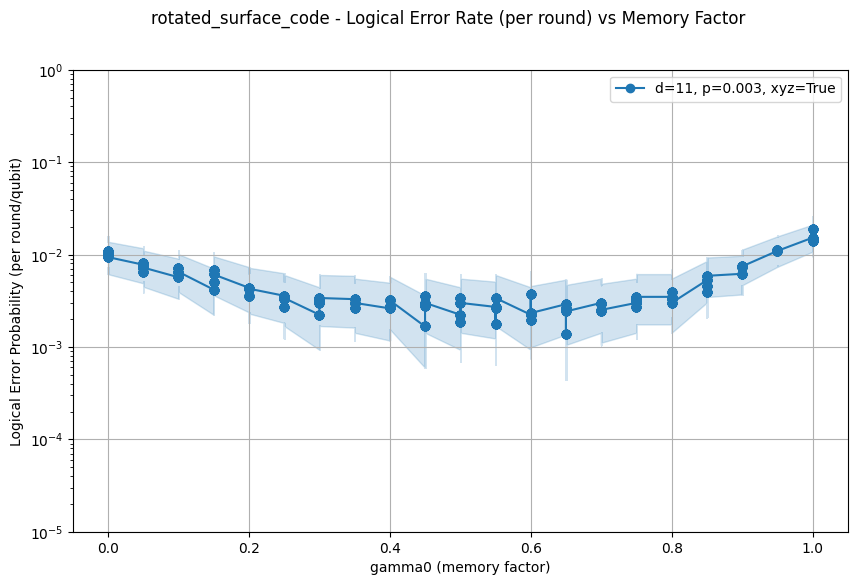

In [11]:
import matplotlib


cmap = matplotlib.colormaps.get_cmap('Spectral')

def group_func(stat):
    return {
        "label": f"""d={stat.json_metadata["d"]}, p={stat.json_metadata["p"]}, xyz={membp_sweep_xyz}""",
        "color": cmap(stat.json_metadata["d"]/max(membp_distances)),
        "linestyle": "-",
    }

def filter_func_gen(p):
    def filter_func(stat):
        return ("mem-bp" == stat.decoder and 
                stat.json_metadata["p"] == p and
                stat.json_metadata["d"] in membp_distances and
                stat.json_metadata["xyz"] == membp_sweep_xyz
               )
    return filter_func

# Render a matplotlib plot of the data.
fig, axs = plt.subplots(1, len(membp_error_rates), figsize=(10, 6))
if not isinstance(axs, list):
    axs = [axs]

for ax, error_rate in zip(axs, membp_error_rates):
    sinter.plot_error_rate(
        ax=ax,
        stats=gamma0_sweep_samples,
        group_func=group_func,
        failure_units_per_shot_func=lambda stats: stats.json_metadata["d"],
        x_func=lambda stat: stat.json_metadata["decoder_params"]["gamma0"],
        filter_func=filter_func_gen(error_rate),
    )

    ax.set_yscale("log")
    ax.set_ylim(1e-5, 1)
    ax.grid()
    ax.set_ylabel("Logical Error Probability (per round/qubit)")
    ax.set_xlabel("gamma0 (memory factor)")
    ax.legend()

plt.suptitle(f"{notebook_str} - Logical Error Rate (per round) vs Memory Factor")

plt.show()

## Optimizing Relay parameters

Below we optimize Relay parameters.
We will use a gradient free optimizer.

In [12]:
# First some useful helper functions to calculate logical error rates.
def get_trial_stderr_per(errors, shots, target):
    LER_est = errors/shots
    if LER_est == 0.:
        return 0., 1., 10000
    standard_error_per = np.sqrt(LER_est*(1-LER_est)/shots) / LER_est

    addl_shots = additional_shots(target, standard_error_per, shots)
    return LER_est, standard_error_per, addl_shots


def additional_shots(target, current, current_shots):
    scale_factor = (current/target)**2
    return int(np.ceil(current_shots*scale_factor))

### Tuning with gradient free optimization
Below we use [nevergrad](https://github.com/facebookresearch/nevergrad) to tune the distribution hyperparameters.

In [13]:
import nevergrad as ng

import relay_bp

# We reduce the number of sets to speed up training
if test:
    opt_budget = 100
    opt_max_shots = int(1E4)
    opt_per_stderr = 0.5
    opt_initial_shots = 100
    opt_num_sets = 100
    opt_num_pre_iter = relay_num_pre_iter
    opt_set_max_iter = relay_set_max_iter
    opt_stop_nconv = 1
    opt_xyz = False
    verbosity = 2
else:
    opt_budget = 100
    opt_max_shots = int(2E5)
    opt_per_stderr = 0.2
    opt_initial_shots = 250
    opt_num_sets = 100
    opt_num_pre_iter = relay_num_pre_iter
    opt_set_max_iter = relay_set_max_iter
    opt_stop_nconv = 1
    opt_xyz = True
    verbosity = 2 

seed = 0

"""We set up the decoder manually without Sinter to utilize its parallel
batch decoder as it is typically more performant than sinter's Python
multiprocessing.

we also reuse shots across cost function calls
to avoid additional noise in the optimization and improve performance.
"""

if optimize:
    detector_data = {}
    obs_data = {}
    dem_matrices = {}
    check_matrix = {}
    observable_matrix = {}
    error_priors = {}
    for circuit_name in circuits:
        opt_circuit = testdata.get_test_circuit(circuit_name, distance=distance, rounds=rounds, error_rate=opt_error_rate)
        if opt_xyz:
            opt_dem = opt_circuit.detector_error_model()
        else:
            opt_circuit = testdata.filter_detectors_by_basis(opt_circuit, circuit_name[-1])
            opt_dem = opt_circuit.detector_error_model()

        dem_matrices[circuit_name] = relay_bp.stim.CheckMatrices.from_dem(opt_dem)
        check_matrix[circuit_name] = dem_matrices[circuit_name].check_matrix
        observable_matrix[circuit_name] = dem_matrices[circuit_name].observables_matrix
        error_priors[circuit_name] = dem_matrices[circuit_name].error_priors
        
        sampler = opt_dem.compile_sampler()
        circ_detector_data, circ_obs_data, _ = sampler.sample(opt_max_shots, return_errors=False)
        circ_detector_data = circ_detector_data.astype(np.uint8)
        circ_obs_data = circ_obs_data.astype(np.uint8)

        # Only use samples that fail mem-bp to train Relay for training performance improvement
        mem_bp_decoder = relay_bp.MinSumBPDecoderF64(
                    check_matrix[circuit_name],
                    error_priors=error_priors[circuit_name],
                    gamma0=min_gamma0,
                    max_iter=opt_num_pre_iter,   
                )
        
        mem_bp_observable_decoder = relay_bp.ObservableDecoderRunner(
            mem_bp_decoder,
            observable_matrix[circuit_name],
            include_decode_result=False,
        )

        decoded_obs_data = mem_bp_observable_decoder.decode_observables_batch(circ_detector_data, parallel=True)
        failures = np.any(circ_obs_data != decoded_obs_data, axis=1)
        failure_locs = np.where(failures)

        if verbosity == 2:
            print(f"For {circuit_name} and {opt_max_shots} there are {np.sum(failures)} failing mem-bp samples to train with.")
        detector_data[circuit_name] = circ_detector_data[failure_locs].astype(np.uint8)
        obs_data[circuit_name] = circ_obs_data[failure_locs].astype(np.uint8)
    
    def gen_cost_function(
        check_matrix, 
        observable_matrix, 
        error_priors, 
        detector_data, 
        obs_data, 
        max_stderr_per_tolerance=opt_per_stderr, 
        initial_shots=opt_initial_shots,
        gamma0=min_gamma0,
        max_shots=opt_max_shots,
        pre_iter=opt_num_pre_iter,
        num_sets=opt_num_sets,
        set_max_iter=opt_set_max_iter,
        stop_nconv=opt_stop_nconv,
        
        
    ):
        def cost_function(gamma_dist_min, gamma_dist_max):
            gamma_dist_interval = (gamma_dist_min, gamma_dist_max)
            if verbosity == 2:
                print(f"Starting cost evaluation for gamma_dist_interval={gamma_dist_interval}") 
    
            observable_decoders = {}
            for circuit_name in circuits:   
                decoder = relay_bp.RelayDecoderF64(
                    check_matrix[circuit_name],
                    error_priors=error_priors[circuit_name],
                    gamma0=gamma0,
                    pre_iter=pre_iter,
                    num_sets=num_sets,
                    set_max_iter=set_max_iter,
                    gamma_dist_interval=gamma_dist_interval,
                    stop_nconv=stop_nconv,
                
                )
        
                observable_decoders[circuit_name] = relay_bp.ObservableDecoderRunner(
                    decoder,
                    observable_matrix[circuit_name],
                    include_decode_result=False,
                )
    
            errors = {circuit_name: 0 for circuit_name in circuits}
            curr_stderr_per = 1.
            curr_shots = initial_shots
            prev_shots = 0

            marginals = []
            for circuit_name in circuits:
                # Decode the observable errors
                decoded_obs_data = observable_decoders[circuit_name].decode_observables_batch(detector_data[circuit_name], parallel=True)
    
                errors[circuit_name] += np.sum(np.any(obs_data[circuit_name] != decoded_obs_data, axis=1))
                
                marginals.append(errors[circuit_name]/max_shots)

            prob_at_least_one_error = testdata.utils.prob_at_least_one_error(marginals)
            
            total_errors = int(prob_at_least_one_error*max_shots)
            
            cost, curr_stderr_per, addl_shots = get_trial_stderr_per(total_errors, max_shots, max_stderr_per_tolerance)

            per_round_cost = cost/rounds
            if verbosity == 2:
                print(f"for (gamma_dist_interval={gamma_dist_interval}) ler per round, per qubit={per_round_cost}")
                print(f"errors: {errors}, total (mem-bp failing) shots: {max_shots}, percent error: {100*curr_stderr_per}%")

            return per_round_cost 
            
        return cost_function
    
    relay_params = ng.p.Instrumentation(
        gamma_dist_min=ng.p.Scalar(init=relay_gamma_dist_interval[0], lower=-0.5, upper=0.5),
        gamma_dist_max=ng.p.Scalar(init=relay_gamma_dist_interval[1], lower=0.0, upper=1.0),
    )
    
    def ensure_gamma_interval_ordered(vals):
        param_dict = vals[1]
        return param_dict["gamma_dist_min"] < param_dict["gamma_dist_max"]
    
    relay_params.register_cheap_constraint(ensure_gamma_interval_ordered)
    
    optimizer = ng.optimizers.TwoPointsDE(parametrization=relay_params, budget=opt_budget)
    optimizer.register_callback("tell", ng.callbacks.ProgressBar())
    cost_function = gen_cost_function(check_matrix, observable_matrix, error_priors, detector_data, obs_data)
    recommendation = optimizer.minimize(cost_function, verbosity=verbosity, batch_mode=False)
    
    opt_gamma0 = min_gamma0
    opt_gamma_dist_interval = [recommendation[1]["gamma_dist_min"].value, recommendation[1]["gamma_dist_max"].value]
    final_cost_function = gen_cost_function(
        check_matrix, observable_matrix, error_priors, detector_data, obs_data, 
        gamma0=opt_gamma0, pre_iter=relay_num_pre_iter, 
        num_sets=relay_num_sets, set_max_iter=relay_set_max_iter, stop_nconv=relay_stop_nconv,
    )
    cost_ler = cost_function(*opt_gamma_dist_interval)
    opt_ler = final_cost_function(*opt_gamma_dist_interval)
    
    print(f"For d={distance} relay-bp optimization with p={opt_error_rate}")
    print(f"Expedited cost function logical error rate: {cost_ler}")
    print(f"Full cost function logical error rate: {opt_ler}")
    print(f"optimized parameters - opt_ewainit_discount_factor: {opt_gamma0}, opt_gamma_dist_interval: {opt_gamma_dist_interval}")

## Performing a detailed error rate characterization

We now perform a dertailed error rate sweep using the (best) values we found for Relay.
We examine the performance with both XZ and XYZ decoding.
We include `msl-bp` (with a large number of iteratios) and `pymatching` for reference.

In [14]:
# Ensure consistent comparison
if not optimize:
    best_relay_gamma_dist = relay_gamma_dist_interval
    best_gamma0 = gamma0
    print(f"Relay parameter optimization was skipped. Using default values specificed at top of notebook - gamma0: {best_gamma0}, gamma dist: {best_relay_gamma_dist}")
else:
    best_gamma0 = min_gamma0
    best_relay_gamma_dist = opt_gamma_dist_interval
    print(f"Using Relay parameters obtained from gradient free optimization")
    print(f"Using the best discount factor: {best_gamma0} and optimized memory factor disorder distribution: {best_relay_gamma_dist} with ler per round: {opt_ler}")

Relay parameter optimization was skipped. Using default values specificed at top of notebook - gamma0: 0.65, gamma dist: [-0.25453802248, 0.98518104204]


In [15]:
def generate_plot_tasks_xz(relay_params, mem_params, msl_params):
    for p in error_rates:
        for circuit_name in circuits:
            circ = testdata.get_test_circuit(circuit_name, distance=distance, rounds=rounds, error_rate=p)
            circ = testdata.filter_detectors_by_basis(circ, circuit_name[-1])
            dem = circ.detector_error_model(decompose_errors=True)
            
            for decoder in all_decoders:
                json_metadata = {
                        'circuit': circuit_name,
                        'p': p,
                        'd': distance,
                        'xyz': False,
                        'decoder_params': {}
                }
                num_shots = select_num_shots(p)
                if decoder == "relay-bp":
                    json_metadata["decoder_params"] = relay_params
                elif decoder == "mem-bp":
                    json_metadata["decoder_params"] = mem_params
                    num_shots = rough_select_num_shots(p)
                elif decoder == "msl-bp":
                    json_metadata["decoder_params"] = msl_params
                    num_shots = rough_select_num_shots(p)
                
                yield sinter.Task(
                    circuit=circ,
                    detector_error_model=dem,
                    decoder=decoder,
                    json_metadata=json_metadata,
                    collection_options=sinter.CollectionOptions(max_shots=num_shots)
                )

def generate_plot_tasks_xyz(relay_params, mem_params, msl_params):
    for p in error_rates:
        for circuit_name in circuits:
            circ = testdata.get_test_circuit(circuit_name, distance=distance, rounds=rounds, error_rate=p)
            dem = circ.detector_error_model(decompose_errors=False)
        
            for decoder in all_decoders:
                if decoder in xz_only_decoders:
                    continue
                json_metadata = {
                        'circuit': circuit_name,
                        'p': p,
                        'd': distance,
                        'xyz': True,
                        'decoder_params': {}
                }
                num_shots = select_num_shots(p)
                if decoder == "relay-bp":
                    json_metadata["decoder_params"] = relay_params
                elif decoder == "mem-bp":
                    json_metadata["decoder_params"] = mem_params
                    num_shots = rough_select_num_shots(p)
                elif decoder == "msl-bp":
                    json_metadata["decoder_params"] = msl_params
                    num_shots = rough_select_num_shots(p)
        
                yield sinter.Task(
                    circuit=circ,
                    detector_error_model=dem,
                    decoder=decoder,
                    json_metadata=json_metadata,
                    collection_options=sinter.CollectionOptions(max_shots=num_shots)
                )

def collect_samples(relay_params, mem_params, msl_params):
    samples = []

    custom_decoders = {
        "relay-bp": SinterDecoder_RelayBP(**relay_params),
        "mem-bp": SinterDecoder_MemBP(**mem_params), 
        "msl-bp": SinterDecoder_MSLBP(**msl_params), 
    }
    samples += sinter_collect(
            itertools.chain(generate_plot_tasks_xz(relay_params, mem_params, msl_params), generate_plot_tasks_xyz(relay_params, mem_params, msl_params)), 
            exp_name="fine_ler_sweep", 
            custom_decoders=custom_decoders,
            print_progress=True,
            save=save_data,
            load=load_data,
        )
    return samples

relay_params = build_relay_params(gamma0=best_gamma0, gamma_dist_interval=best_relay_gamma_dist)
mem_params = build_mem_params(gamma0=best_gamma0)
msl_params = build_msl_params()
# Collect the samples
fine_ler_sweep_samples_separated_basis = collect_samples(relay_params, mem_params, msl_params)
fine_ler_sweep_samples = testdata.synthesize_joint_samples(fine_ler_sweep_samples_separated_basis, circuits)

Starting 96 workers...


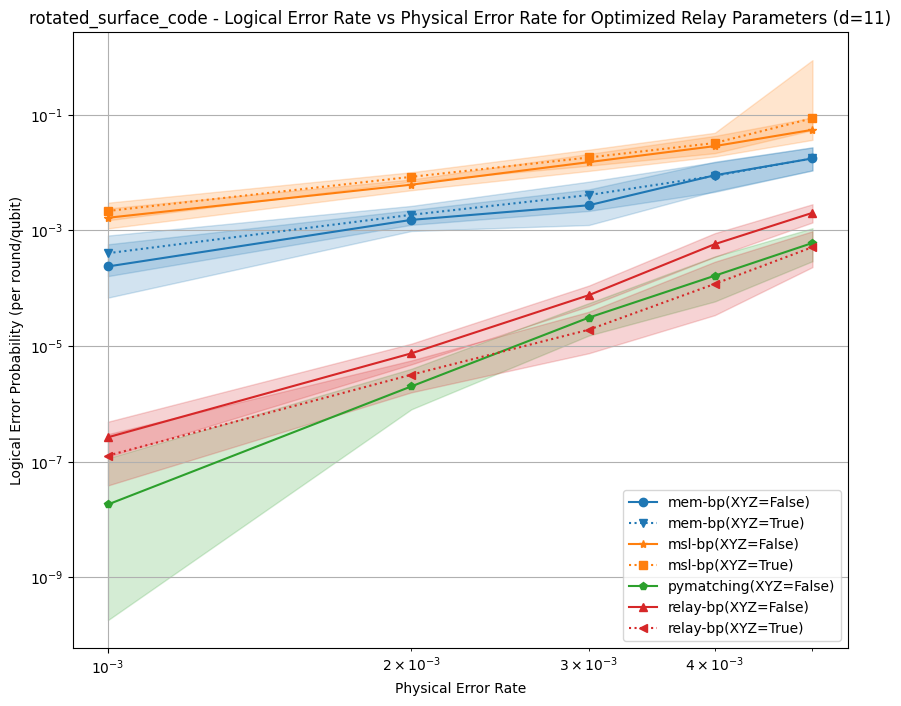

In [16]:
def group_func(stat):
    return {
        "label": f'{stat.decoder}(XYZ={stat.json_metadata["xyz"]})',
        "color": stat.decoder,
        "linestyle": "--" if stat.json_metadata["xyz"] else  "-",
    }

def filter_func(stat):
    to_return = (
            "xyz" in stat.json_metadata and 
            stat.json_metadata["p"] in error_rates and
            stat.json_metadata["d"] == distance)
    if stat.decoder == "relay-bp":
            return stat.json_metadata["decoder_params"] == relay_params and to_return
    elif stat.decoder == "mem-bp":
            return stat.json_metadata["decoder_params"] == mem_params and to_return   
    elif stat.decoder == "msl-bp":
            return stat.json_metadata["decoder_params"] == msl_params and to_return   
    return to_return

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sinter.plot_error_rate(
    ax=ax,
    stats=fine_ler_sweep_samples,
    failure_units_per_shot_func=lambda stats: stats.json_metadata['d'],
    group_func=group_func,
    x_func=lambda stat: stat.json_metadata['p'],
    filter_func=filter_func,
)

ax.loglog()
ax.grid()
ax.set_title(f'{notebook_str} - Logical Error Rate vs Physical Error Rate for Optimized Relay Parameters (d={distance})')
ax.set_ylabel('Logical Error Probability (per round/qubit)')
ax.set_xlabel('Physical Error Rate')
ax.legend()

plt.show()

In [17]:
import math
def stderr(stat):
    stderr_mean = math.sqrt(stat.errors/stat.shots*(1-stat.errors/stat.shots))*math.sqrt(1/stat.shots)
    ler_stderr = 1-(1-stderr_mean)**(1/stat.json_metadata["d"])
    return ler_stderr

def print_decoder_outputs(samples):
    samples = [sample for sample in samples if filter_func(sample)]
    groups = sinter.group_by(samples, key=lambda stat: (stat.decoder, stat.json_metadata["xyz"]))
    
    for decoder, stats in groups.items():
        stats = sorted(stats, key=lambda stat: stat.json_metadata["p"])
        lers = sorted([1-(1-stat.errors/stat.shots)**(1/stat.json_metadata["d"]) for stat in stats])
        ler_stderrs = sorted([stderr(stat) for stat in stats])
        #lers, ler_stderrs = [ler_stderr(stat) for stat in stats]
        print(f"(Decoder, XYZ): {decoder} --- LERS: {lers} -- stderrs: {ler_stderrs}")
        
print_decoder_outputs(fine_ler_sweep_samples)

(Decoder, XYZ): ('mem-bp', False) --- LERS: [0.00023664343826113043, 0.0015021405321860026, 0.0026717708765090498, 0.00853704879880779, 0.01593863023497133] -- stderrs: [6.549164171076871e-05, 0.0001634211763350546, 0.00048357712515978424, 0.0011703185494090773, 0.0015093041398872575]
(Decoder, XYZ): ('relay-bp', False) --- LERS: [2.63636711128612e-07, 7.45482332031866e-06, 7.548302744153634e-05, 0.0005743739608879972, 0.0019831849402821566] -- stderrs: [4.8955984710552514e-08, 8.231864663255095e-07, 8.279117223453092e-06, 7.195508281021556e-05, 0.00018707407152751543]
(Decoder, XYZ): ('msl-bp', False) --- LERS: [0.0016314246301479818, 0.005956059510407452, 0.013930905171799735, 0.024407093850178918, 0.039759547745437995] -- stderrs: [0.00017013814662891757, 0.00031424171257521394, 0.0010114887390204608, 0.0017465358788716356, 0.001970783071111981]
(Decoder, XYZ): ('relay-bp', True) --- LERS: [1.2727280829238907e-07, 3.1818688027707154e-06, 1.909273164857339e-05, 0.00011825171071955243